In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
file_path = 'wmt14_translate_de-en_test.csv'
data = pd.read_csv(file_path)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3003 entries, 0 to 3002
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   de      3003 non-null   object
 1   en      3003 non-null   object
dtypes: object(2)
memory usage: 47.1+ KB


In [4]:
data.head()

,de,en
0,Ursprünglich war die Schulhofsanierung sogar s...,The school yard renovation was originally plan...
1,Von daher werden sie gegen ihren Ex-Coach sich...,"Consequently, they will be particularly motiva..."
2,"Sie sind nicht alle erfahrene Rennfahrer, sond...","They're not all experienced racers, but people..."
3,In seinem Brief macht Snowden den deutschen Be...,The letter extends an offer to cooperate with ...
4,Ein Anwohner im Bischof-Freundorfer-Weg meldet...,The residents of the Bischof-Freundorfer-Weg r...


In [5]:
data.isnull().sum()

de    0
en    0
dtype: int64

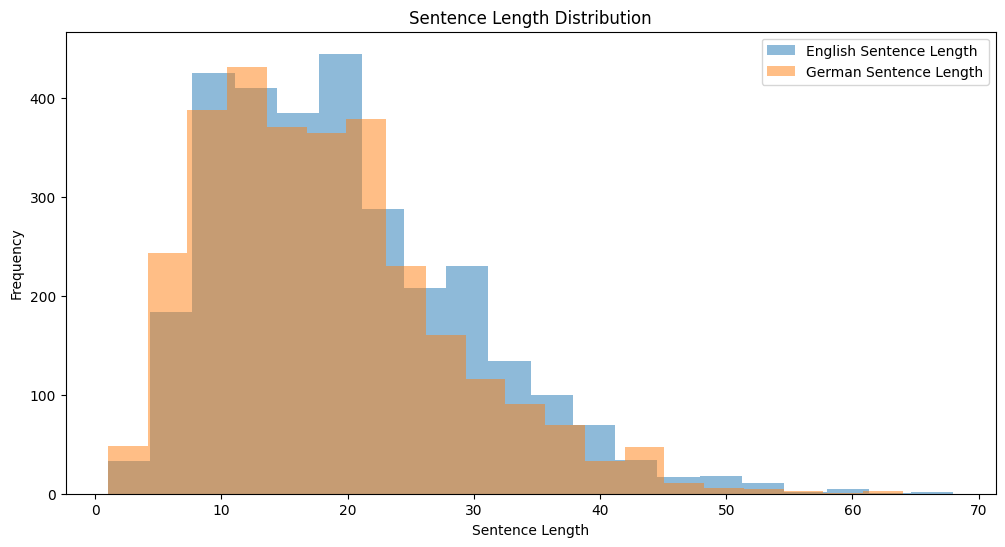

In [6]:
data['en_len'] = data['en'].apply(lambda x: len(x.split()))
data['de_len'] = data['de'].apply(lambda x: len(x.split()))

plt.figure(figsize=(12, 6))
plt.hist(data['en_len'], bins=20, alpha=0.5, label='English Sentence Length')
plt.hist(data['de_len'], bins=20, alpha=0.5, label='German Sentence Length')
plt.title('Sentence Length Distribution')
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [7]:
from transformers import AutoTokenizer

# Load tokenizers
opus_tokenizer = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-de")
t5_tokenizer = AutoTokenizer.from_pretrained("google-t5/t5-small")

# Tokenize the dataset
def tokenize_data(data, tokenizer, max_length=128, source_col="en", target_col="de"):
    source_tokens = tokenizer(
        list(data[source_col]),
        max_length=max_length,
        padding="max_length",
        truncation=True,
        return_tensors="pt",
    )
    target_tokens = tokenizer(
        list(data[target_col]),
        max_length=max_length,
        padding="max_length",
        truncation=True,
        return_tensors="pt",
    )
    return source_tokens, target_tokens

# Tokenize for both models
opus_source, opus_target = tokenize_data(data, opus_tokenizer)
t5_source, t5_target = tokenize_data(data, t5_tokenizer)


/Users/sasankperumal/Documents/DL_HW2/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/sasankperumal/Documents/DL_HW2/venv/lib/python3.11/site-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


In [10]:
import numpy as np
import torch

# Split dataset into train and test sets using numpy
def train_test_split_np(data, test_size=0.2, random_seed=42):
    np.random.seed(random_seed)
    indices = np.random.permutation(len(data))
    split_idx = int(len(data) * (1 - test_size))
    train_indices, test_indices = indices[:split_idx], indices[split_idx:]
    return data.iloc[train_indices], data.iloc[test_indices]

# Split the dataset
train_data, test_data = train_test_split_np(data)

# Tokenize train and test sets for both models
opus_train_source, opus_train_target = tokenize_data(train_data, opus_tokenizer)
opus_test_source, opus_test_target = tokenize_data(test_data, opus_tokenizer)

t5_train_source, t5_train_target = tokenize_data(train_data, t5_tokenizer)
t5_test_source, t5_test_target = tokenize_data(test_data, t5_tokenizer)

# Convert to PyTorch datasets
class TranslationDataset(torch.utils.data.Dataset):
    def __init__(self, source, target):
        self.source = source
        self.target = target

    def __len__(self):
        return self.source["input_ids"].shape[0]

    def __getitem__(self, idx):
        return {
            "input_ids": self.source["input_ids"][idx],
            "attention_mask": self.source["attention_mask"][idx],
            "labels": self.target["input_ids"][idx],
        }

opus_train_dataset = TranslationDataset(opus_train_source, opus_train_target)
opus_test_dataset = TranslationDataset(opus_test_source, opus_test_target)

t5_train_dataset = TranslationDataset(t5_train_source, t5_train_target)
t5_test_dataset = TranslationDataset(t5_test_source, t5_test_target)


In [14]:
import torch
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, AdamW
from torch.utils.data import DataLoader

# Load models and tokenizers
opus_model = AutoModelForSeq2SeqLM.from_pretrained("Helsinki-NLP/opus-mt-en-de")
t5_model = AutoModelForSeq2SeqLM.from_pretrained("google-t5/t5-small")

# Move models to CPU
device = torch.device("cpu")
opus_model.to(device)
t5_model.to(device)

# Hyperparameters
EPOCHS = 3
BATCH_SIZE = 8
LEARNING_RATE = 5e-5

# Define data loaders
def create_dataloader(dataset, batch_size):
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

opus_train_loader = create_dataloader(opus_train_dataset, BATCH_SIZE)
t5_train_loader = create_dataloader(t5_train_dataset, BATCH_SIZE)

# Training loop
def train_model(model, dataloader, optimizer, device, epochs):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in dataloader:
            # Move data to device
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(dataloader):.4f}")

# Optimizers
opus_optimizer = AdamW(opus_model.parameters(), lr=LEARNING_RATE)
t5_optimizer = AdamW(t5_model.parameters(), lr=LEARNING_RATE)

# Train Helsinki-NLP model
print("Training Helsinki-NLP model...")
train_model(opus_model, opus_train_loader, opus_optimizer, device, EPOCHS)

# Train T5 model
print("Training T5 model...")
train_model(t5_model, t5_train_loader, t5_optimizer, device, EPOCHS)


/Users/sasankperumal/Documents/DL_HW2/venv/lib/python3.11/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training Helsinki-NLP model...
Epoch 1/3, Loss: 1.2065
Epoch 2/3, Loss: 0.7331
Epoch 3/3, Loss: 0.5460
Training T5 model...


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch 1/3, Loss: 1.6821
Epoch 2/3, Loss: 0.6187
Epoch 3/3, Loss: 0.5226


In [15]:
# Save the trained Helsinki-NLP model
opus_model_save_path = "./trained_opus_model"
opus_model.save_pretrained(opus_model_save_path)
opus_tokenizer.save_pretrained(opus_model_save_path)

# Save the trained T5 model
t5_model_save_path = "./trained_t5_model"
t5_model.save_pretrained(t5_model_save_path)
t5_tokenizer.save_pretrained(t5_model_save_path)

print(f"Models saved successfully!")


/Users/sasankperumal/Documents/DL_HW2/venv/lib/python3.11/site-packages/transformers/modeling_utils.py:2817: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 512, 'num_beams': 4, 'bad_words_ids': [[58100]]}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


Models saved successfully!


In [16]:
from sacrebleu import corpus_bleu, corpus_chrf
from rouge_score import rouge_scorer
from bert_score import score

# Function to generate predictions
def generate_predictions(model, tokenizer, dataloader, device):
    model.eval()
    predictions = []
    references = []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"]

            outputs = model.generate(input_ids, max_length=128, num_beams=4)
            predictions += [tokenizer.decode(output, skip_special_tokens=True) for output in outputs]
            references += [tokenizer.decode(label, skip_special_tokens=True) for label in labels]
    return predictions, references

# Create test dataloaders
opus_test_loader = create_dataloader(opus_test_dataset, BATCH_SIZE)
t5_test_loader = create_dataloader(t5_test_dataset, BATCH_SIZE)

# Generate predictions for both models
print("Generating predictions for Helsinki-NLP model...")
opus_predictions, opus_references = generate_predictions(opus_model, opus_tokenizer, opus_test_loader, device)

print("Generating predictions for T5 model...")
t5_predictions, t5_references = generate_predictions(t5_model, t5_tokenizer, t5_test_loader, device)

# Compute evaluation metrics
def evaluate_model(predictions, references):
    bleu = corpus_bleu(predictions, [references]).score
    chrf = corpus_chrf(predictions, [references]).score
    scorer = rouge_scorer.RougeScorer(["rouge1", "rougeL"], use_stemmer=True)
    rouge_scores = [scorer.score(ref, pred) for ref, pred in zip(references, predictions)]
    rouge1 = sum([r["rouge1"].fmeasure for r in rouge_scores]) / len(rouge_scores)
    rougeL = sum([r["rougeL"].fmeasure for r in rouge_scores]) / len(rouge_scores)
    bert = score(predictions, references, lang="de", verbose=False)
    bert_f1 = bert[2].mean().item()
    return {"BLEU": bleu, "ChrF": chrf, "ROUGE-1": rouge1, "ROUGE-L": rougeL, "BERTScore": bert_f1}

# Evaluate both models
print("Evaluating Helsinki-NLP model...")
opus_metrics = evaluate_model(opus_predictions, opus_references)

print("Evaluating T5 model...")
t5_metrics = evaluate_model(t5_predictions, t5_references)

# Display metrics
print("Helsinki-NLP Metrics:", opus_metrics)
print("Google-T5 Metrics:", t5_metrics)


Generating predictions for Helsinki-NLP model...
Generating predictions for T5 model...
Evaluating Helsinki-NLP model...
Evaluating T5 model...
Helsinki-NLP Metrics: {'BLEU': 21.570023633679433, 'ChrF': 52.35008889906947, 'ROUGE-1': 0.5182763264414103, 'ROUGE-L': 0.4713842486009244, 'BERTScore': 0.8410338759422302}
Google-T5 Metrics: {'BLEU': 13.7371451491362, 'ChrF': 38.16474631915072, 'ROUGE-1': 0.3276152803740502, 'ROUGE-L': 0.2945219691273232, 'BERTScore': 0.5115270018577576}
